In [121]:
import os
import numpy as np
import igraph as ig
import matplotlib.pyplot as plt
import pandas as pd
import random
from src.utils import plot_graph, prepare_graph, analyze_graph, random_walk, random_diffusion
from src.crud import get_author_to_author, get_distinct_authors
from src.config import get_db_connection
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from scipy.stats import gaussian_kde
import seaborn as sns

USE_MINI = False

In [2]:
if USE_MINI:
    db_path = "../../../data/twitter_small.db"
else:
    db_path = "../../../data/twitter.db"
con = get_db_connection(db_path=db_path, use_dict_reponses=False)
reply_edges = get_author_to_author(con, response_type="replied_to")
con.close()
con = get_db_connection(db_path=db_path)
authors = get_distinct_authors(con)
con.close()
print(f"num vertices: {len(authors)}")
print(reply_edges[:3])
pd.DataFrame(reply_edges).head()

num vertices: 481467
[('307001802', '41077970'), ('786625296', '338985020'), ('2431501916', '16717501')]


,0,1
0,307001802,41077970
1,786625296,338985020
2,2431501916,16717501
3,3181309406,26735736
4,2349646720,130509788


Order: 24553
Size: 28827
No .of Components: 1
Size of largest component: 24553
Density: 9.563965581428792e-05
Transitivity: 0.21998502913719503


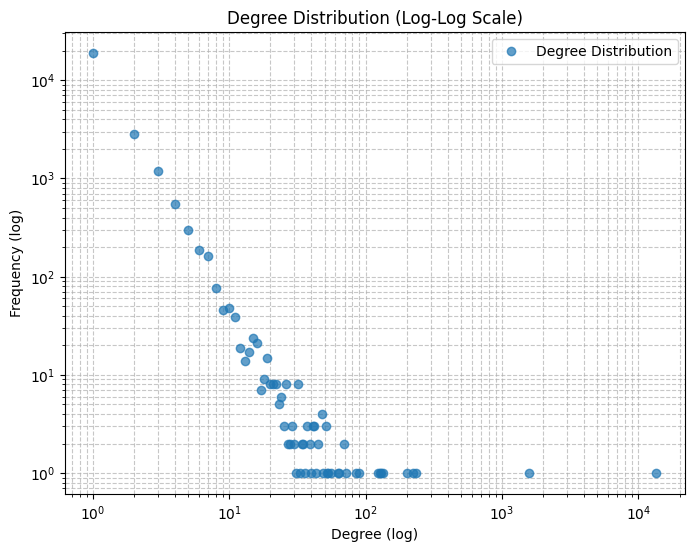

In [3]:
reply_graph = ig.Graph(len(authors))
reply_graph["title"] = "reply network"
reply_graph.vs["name"] = authors
reply_graph.add_edges(reply_edges)
reply_graph, rp_layout = prepare_graph(
    reply_graph,
    layout=reply_graph.layout_fruchterman_reingold(niter=100),
)
g = reply_graph.components().giant()
analyze_graph(g)

# Task 3.1

In [4]:
starting_index = random.randint(0, g.vcount() - 1)
token_ratios = random_walk(g, g.vs[starting_index], iterations= 2 * g.vcount())
g.vs["token_ratios"] = token_ratios

In [5]:
order = g.vcount()
# Small World Graph
nei = round(g.average_path_length())
swg = ig.Graph.Watts_Strogatz(dim=1, size=order, nei=nei, p=0.16)
swg.vs["token_ratios"] = random_walk(swg, swg.vs[starting_index], iterations = 2 * order)
# Erdos Reyni
p = g.ecount() / (order * (order - 1) / 2)
erg = ig.Graph.Erdos_Renyi(n=order, p=p)
erg.vs["token_ratios"] = random_walk(erg, erg.vs[starting_index], iterations = 2 * order)
# Barabasi
avg_degree = g.ecount() / order
m = round(avg_degree)
bag = ig.Graph.Barabasi(n=order, m=m)
bag.vs["token_ratios"] = random_walk(bag, bag.vs[starting_index], iterations = 2 * order)
# Rewired
rewired = g.copy()
rewired.rewire()
rewired.vs["token_ratios"] = random_walk(rewired, rewired.vs[starting_index], iterations = 2 * order)

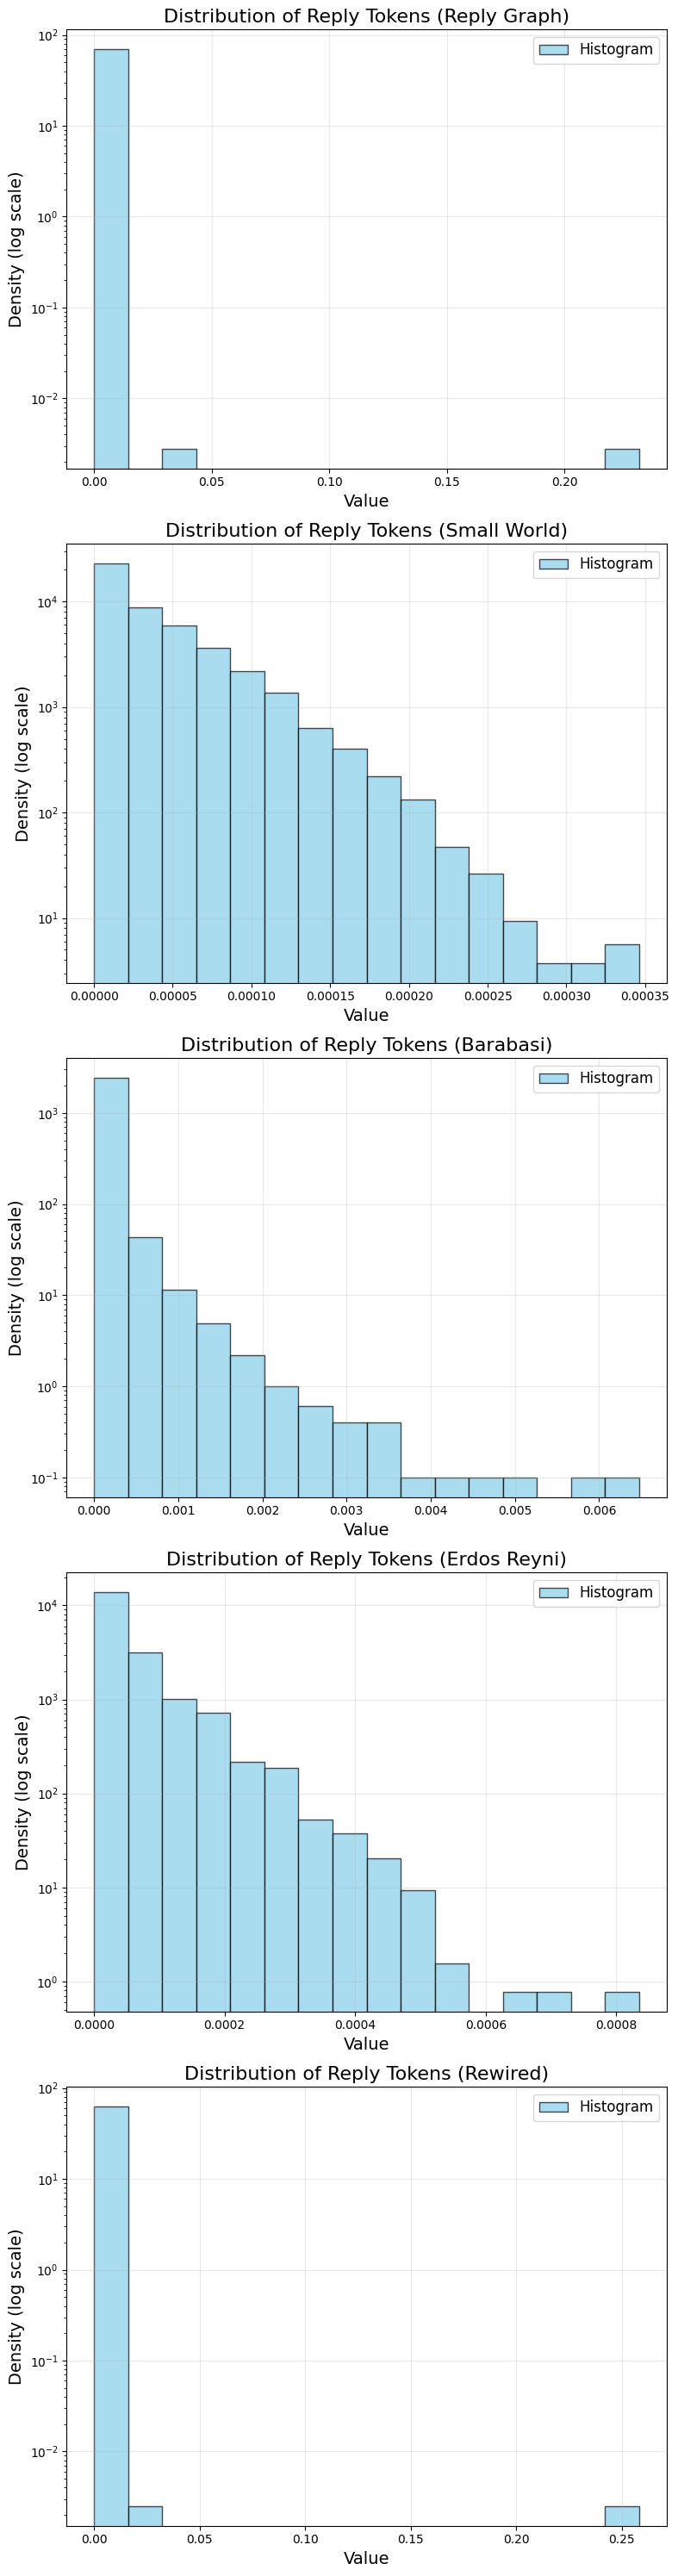

In [6]:
datasets = {
    "Reply Graph": g.vs["token_ratios"],
    "Small World": swg.vs["token_ratios"],
    "Barabasi": bag.vs["token_ratios"],
    "Erdos Reyni": erg.vs["token_ratios"],
    "Rewired": rewired.vs["token_ratios"],
}

num_datasets = len(datasets)
fig, axes = plt.subplots(nrows=num_datasets, ncols=1, figsize=(8, 6 * num_datasets))
for ax, (label, data) in zip(axes, datasets.items()):
    ax.hist(data, bins=16, density=True, color="skyblue", edgecolor="black", alpha=0.7, label="Histogram")

    ax.set_title(f"Distribution of Reply Tokens ({label})", fontsize=16)
    ax.set_xlabel("Value", fontsize=14)
    ax.set_yscale("log")
    ax.set_ylabel("Density (log scale)", fontsize=14)

    ax.legend(fontsize=12)
    ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()

# Task 3.2
#### Function Requirements
1. **Inputs**:
   - `graph`: The network structure.
   - `start`: Initial actor to start diffusion.
   - `iterations`: Number of diffusion rounds.
   - `beta`: Probability of passing the information.

2. **Process**:
   - At each iteration:
     - All `+` actors attempt to spread information to their neighbors.
     - Each neighbor switches to `+` with probability `beta`.

3. **Output**:
   - Return the total count of `+` actors after all iterations.

#### Experiment
Run the function on five networks and analyze:
- Factors that increase/decrease diffusion speed (e.g., network structure, `beta`, initial starting point).

In [7]:
_ = random_diffusion(g, iterations=1000, beta=0.00000000000000000000000000000000000001)
print(f"{len(_[0]) / g.vcount()}%")
print(_[1])

All nodes infected after 13 rounds.
1.0%
24553


In [8]:
# Todo: loop datasets and bootstrap count of infected individuals, plot their distributions
pairs = [(g, "reply"), (swg, "SW"), (bag, "BA"), (rewired, "rewire"), (erg, "ER")]
bootstrap_rounds = 5
betas = [0.001, 0.01, 0.05]
results = []
for pair in pairs:
    graph: ig.Graph = pair[0]
    graph_name = pair[1]
    print(f"Running {graph_name}")
    trans = graph.transitivity_avglocal_undirected()
    avg_path = graph.average_path_length()
    for _ in range(bootstrap_rounds):
        start_index = random.randint(0, graph.vcount() - 1)
        start_node: ig.Vertex = graph.vs[start_index]
        start_neighbors = len(start_node.neighbors())
        start_betweenness = start_node.betweenness()
        for beta in betas:
            iterations = 10
            _, infected_count = random_diffusion(graph, actor=start_node, beta=beta, iterations=iterations)
            result = {
                "graph": graph_name,
                "start_index": start_index,
                "starting_neighbors": start_neighbors,
                "starting_betweenness": start_betweenness,
                "transitivity": trans,
                "components": len(graph.components()),
                "beta": beta,
                "average_path": avg_path,
                "iterations": iterations,
                "number_infected": infected_count
            }
            results.append(result)
res_df = pd.DataFrame(results)

Running reply
Running SW
Running BA
Running rewire
Running ER


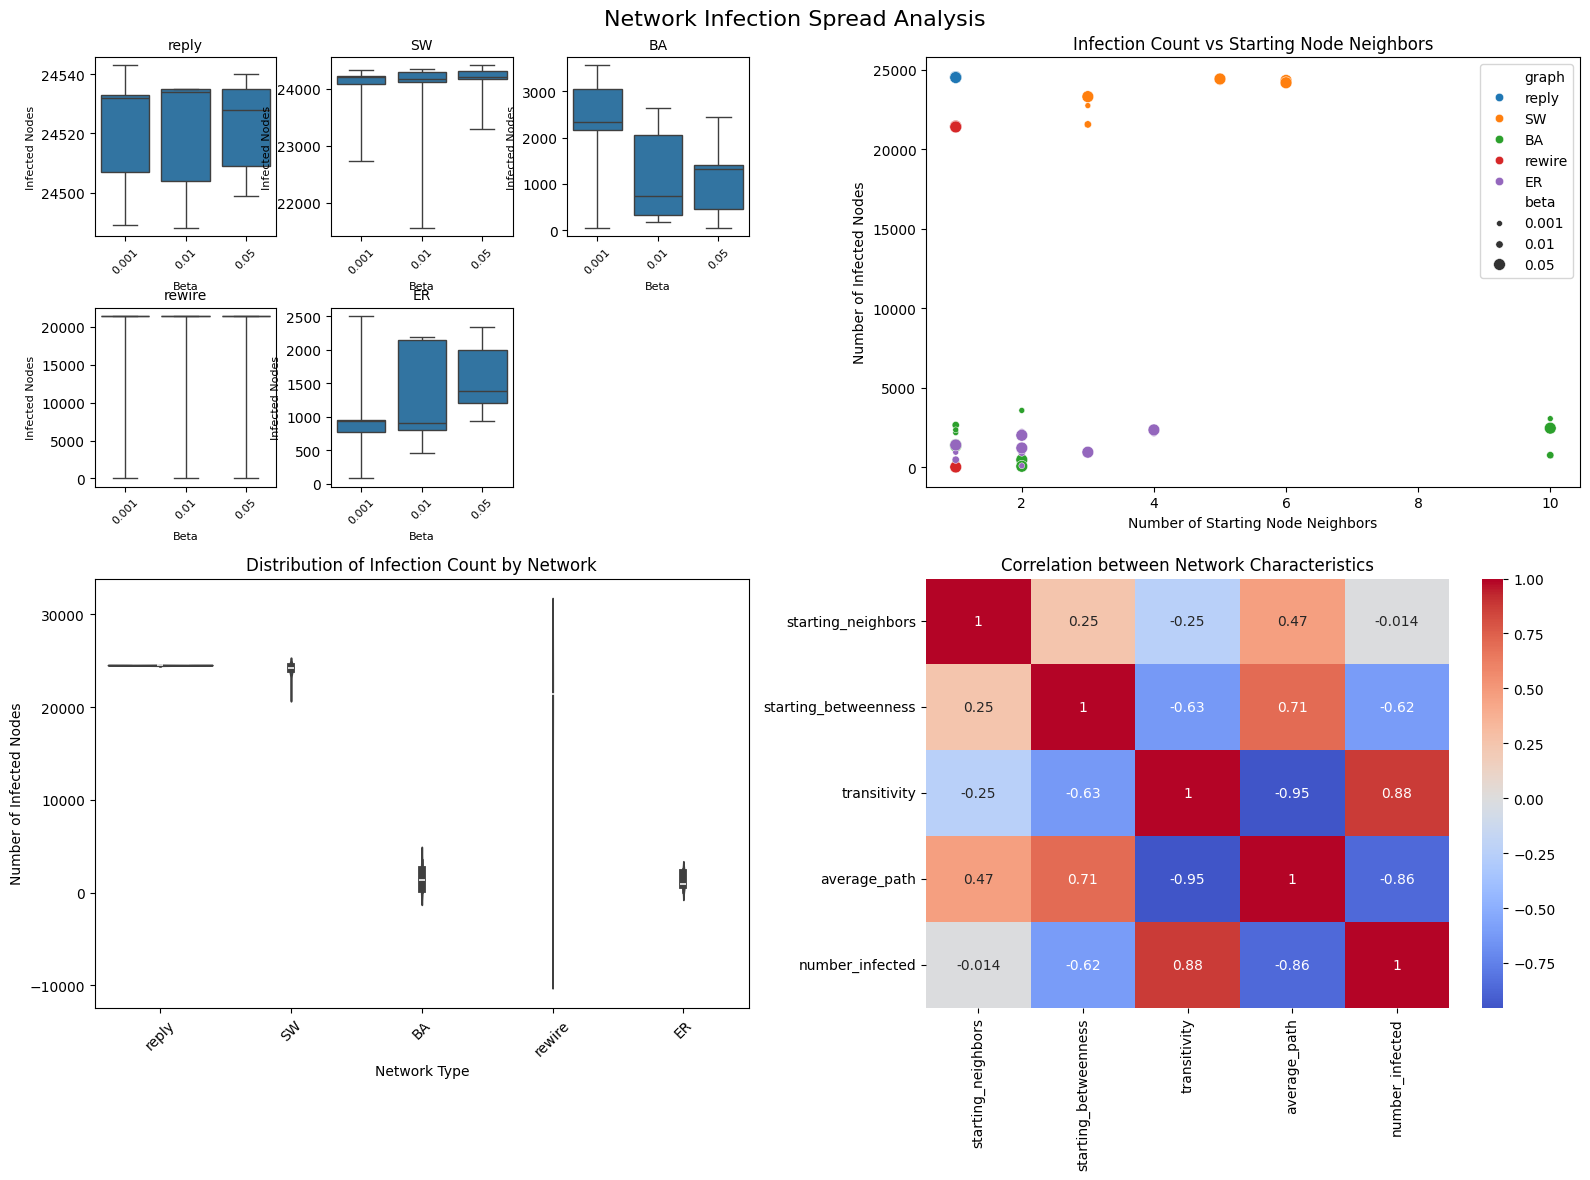

In [27]:
fig = plt.figure(figsize=(16, 12))
gs = fig.add_gridspec(2, 2)
# Create a nested grid for the first subplot area
gs_inner = gs[0, 0].subgridspec(2, 3, wspace=0.3, hspace=0.4)
fig.suptitle('Network Infection Spread Analysis', fontsize=16)
# Multiple Boxplots of Infection Count by Beta
graphs = res_df['graph'].unique()
for i, graph in enumerate(graphs):
    graph_data = res_df[res_df['graph'] == graph]
    # Determine the subplot position
    row = i // 3
    col = i % 3
    # Create subplot in the inner grid
    ax_inner = fig.add_subplot(gs_inner[row, col])
    sns.boxplot(x='beta', y='number_infected', 
                data=graph_data,
                showfliers=False,
                whis=[0, 100],
                ax=ax_inner)
    ax_inner.set_title(graph, fontsize=10)
    ax_inner.tick_params(axis='x', rotation=45, labelsize=8)
    ax_inner.set_xlabel('Beta', fontsize=8)
    ax_inner.set_ylabel('Infected Nodes', fontsize=8)
# Scatter plot of Starting Neighbors vs Infection Count
ax2 = fig.add_subplot(gs[0, 1])
scatter = sns.scatterplot(x='starting_neighbors', y='number_infected', 
                           hue='graph', size='beta', 
                           data=res_df, ax=ax2)
ax2.set_title('Infection Count vs Starting Node Neighbors')
ax2.set_xlabel('Number of Starting Node Neighbors')
ax2.set_ylabel('Number of Infected Nodes')
# Violin plot of Infection Count by Network
ax3 = fig.add_subplot(gs[1, 0])
sns.violinplot(x='graph', y='number_infected', 
               data=res_df, ax=ax3)
ax3.set_title('Distribution of Infection Count by Network')
ax3.set_xlabel('Network Type')
ax3.set_ylabel('Number of Infected Nodes')
ax3.tick_params(axis='x', rotation=45)
# Heatmap of Correlation between Network Characteristics and Infection
ax4 = fig.add_subplot(gs[1, 1])
correlation_df = res_df.groupby('graph').agg({
    'starting_neighbors': 'mean',
    'starting_betweenness': 'mean',
    'transitivity': 'mean',
    'average_path': 'mean',
    'number_infected': 'mean'
}).reset_index()

correlation_matrix = correlation_df.set_index('graph').corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', 
            center=0, ax=ax4)
ax4.set_title('Correlation between Network Characteristics')

plt.tight_layout()
plt.show()

# Task 3.3
#### Task
Simulate an opinion diffusion process where:
- Actors have two states: `+` (opinion positive) and `-` (opinion negative).
- Initially, all actors have opinion `-`.
  
#### Function Requirements
1. **Inputs**:
   - `graph`: The network structure.
   - `initial_positive`: Number of actors whose opinion is set to `+` initially.
   - `iterations`: Number of diffusion rounds.
   - `th`: Opinion change threshold.

2. **Process**:
   - At each iteration:
     - Actors with state `+` count their neighbors' opinions.
     - If the proportion of `-` neighbors is greater than or equal to the threshold `th`, the actor switches to opinion `-`.

3. **Output**:
   - Return the count of actors with opinion `+` after all iterations.

#### Experiment
Run the function on five networks and analyze:
- Factors that affect the speed of opinion adoption (e.g., network structure, `th`, initial conditions).


In [205]:
def random_opinion(g: ig.Graph, th: int, initial_positive: int, iterations: int = 100) -> list:
    g = g.copy()
    g.vs["convinced"] = False
    starting_indices = random.choices([i for i in range(g.vcount())], k=initial_positive)
    g.vs[starting_indices]["convinced"] = True

    for _ in range(iterations):
        convinced_actors: ig.VertexSeq = g.vs.select(convinced_eq=True)
        for actor in convinced_actors:
            neighbors = actor.neighbors()
            if sum([n["convinced"] for n in neighbors]) > th:
                g.vs[[n.index for n in neighbors]]["convinced"] = True

    return len(g.vs.select(convinced_eq=True))
random_opinion(g, th=100, initial_positive=15_000, iterations=5)

19441

In [209]:
bootstrap_rounds = 10
initial_positive = [1_000, 5_000, 10_000, 15_000]
thresholds = [5, 10, 20]
results = []
for pair in pairs:
    graph: ig.Graph = pair[0]
    graph_name = pair[1]
    print(f"Running {graph_name}")
    trans = graph.transitivity_avglocal_undirected()
    avg_path = graph.average_path_length()
    for _ in range(bootstrap_rounds):
        start_index = random.randint(0, graph.vcount() - 1)
        start_node: ig.Vertex = graph.vs[start_index]
        start_neighbors = len(start_node.neighbors())
        start_betweenness = start_node.betweenness()
        for thresh in thresholds:
            for init in initial_positive:
                iterations = 5
                convinced_count = random_opinion(g, th=thresh, initial_positive=init, iterations=iterations)
                result = {
                    "graph": graph_name,
                    "start_index": start_index,
                    "starting_neighbors": start_neighbors,
                    "starting_betweenness": start_betweenness,
                    "transitivity": trans,
                    "components": len(graph.components()),
                    "initial_positive": init,
                    "average_path": avg_path,
                    "iterations": iterations,
                    "threshold": thresh,
                    "number_convinced": convinced_count
                }
                results.append(result)
opinion_df = pd.DataFrame(results)

Running reply
Running SW
Running BA
Running rewire
Running ER


In [210]:
opinion_df.head()

,graph,start_index,starting_neighbors,starting_betweenness,transitivity,components,initial_positive,average_path,iterations,threshold,number_convinced
0,reply,7482,9,317857.901739,0.219985,1,1000,3.150966,5,5,983
1,reply,7482,9,317857.901739,0.219985,1,5000,3.150966,5,5,19899
2,reply,7482,9,317857.901739,0.219985,1,10000,3.150966,5,5,20972
3,reply,7482,9,317857.901739,0.219985,1,15000,3.150966,5,5,21735
4,reply,7482,9,317857.901739,0.219985,1,1000,3.150966,5,10,976
